# Stock market forecasting using Time Series analysis

### What is a Stock market?

The stock market is a market that enables the seamless exchange of buying and selling of company stocks. Every Stock Exchange has its own Stock Index value. The index is the average value that is calculated by combining several stocks. This helps in representing the entire stock market and predicting the market’s movement over time. The stock market can have a huge impact on people and the country’s economy as a whole. Therefore, predicting the stock trends in an efficient manner can minimize the risk of loss and maximize profit.

**Here in this notebook we will forecast the stock price of ARCH CAPITAL GROUP using ARIMA model**

### What is ARIMA?
Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.


ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.



### Load all the required libraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [ ]:
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0
...,...,...,...,...,...,...
2017-11-06,94.490,95.650,94.020,95.550,420192,0
2017-11-07,95.860,95.950,95.200,95.560,464011,0
2017-11-08,95.410,95.900,94.890,95.450,471756,0


Visualize the per day closing price of the stock.

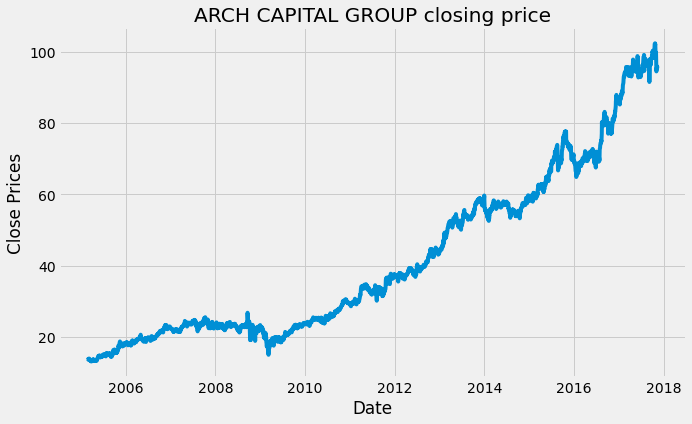

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

### We can also visualize the data in our series through a probability distribution too.

In [ ]:
df_close = stock_data['Close']

<AxesSubplot:ylabel='Density'>

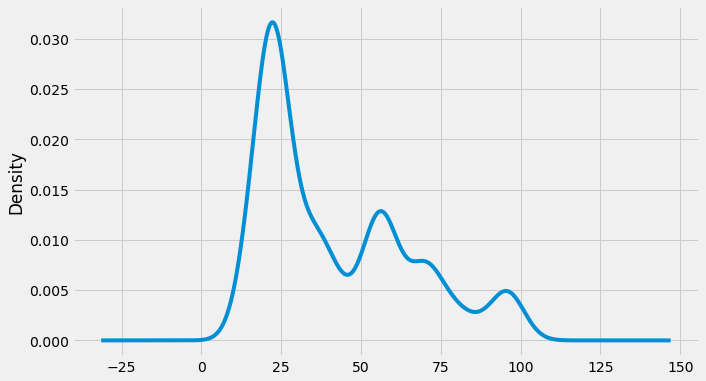

In [ ]:
#Distribution of the dataset
df_close.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

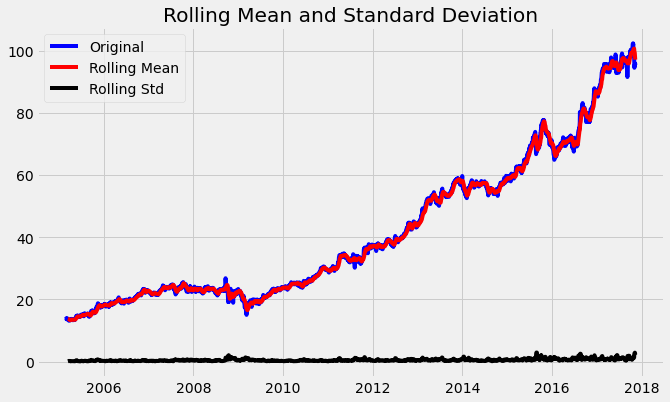

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

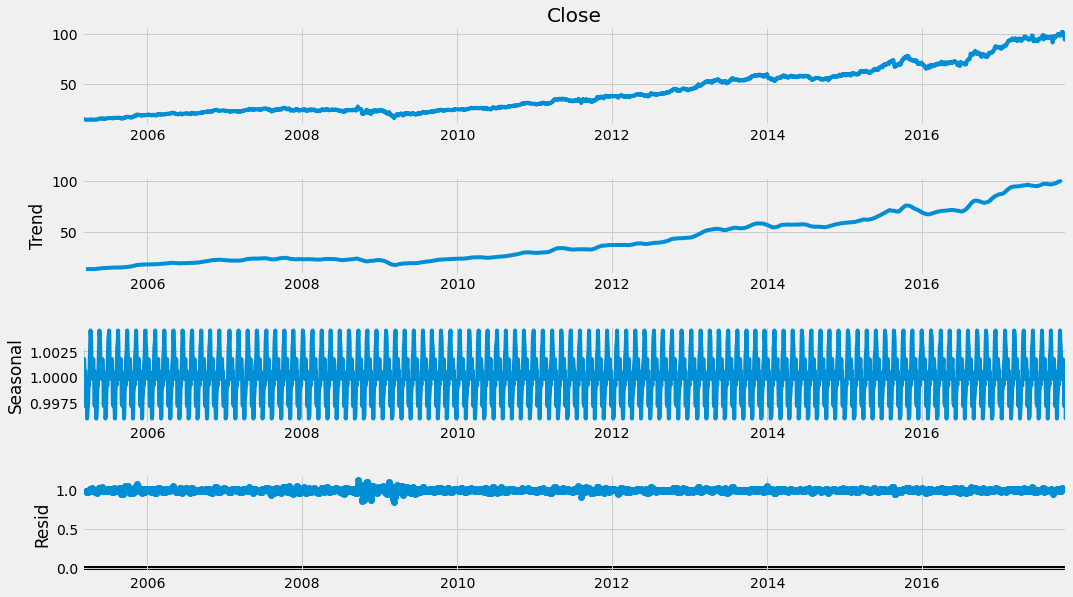

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

In [ ]:
result.seasonal

Date
2005-02-25    1.003715
2005-02-28    1.002632
2005-03-01    1.000316
2005-03-02    1.000346
2005-03-03    1.000180
                ...   
2017-11-06    0.997465
2017-11-07    0.998130
2017-11-08    0.995995
2017-11-09    0.996282
2017-11-10    0.997603
Name: seasonal, Length: 3201, dtype: float64

In [ ]:
result.trend

Date
2005-02-25   NaN
2005-02-28   NaN
2005-03-01   NaN
2005-03-02   NaN
2005-03-03   NaN
              ..
2017-11-06   NaN
2017-11-07   NaN
2017-11-08   NaN
2017-11-09   NaN
2017-11-10   NaN
Name: trend, Length: 3201, dtype: float64

In [ ]:
result.resid

Date
2005-02-25   NaN
2005-02-28   NaN
2005-03-01   NaN
2005-03-02   NaN
2005-03-03   NaN
              ..
2017-11-06   NaN
2017-11-07   NaN
2017-11-08   NaN
2017-11-09   NaN
2017-11-10   NaN
Name: resid, Length: 3201, dtype: float64

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


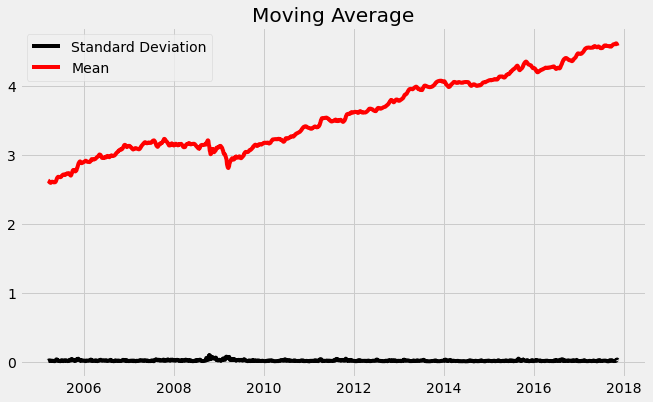

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

### Divide training and testing data

In [ ]:
train_data = df_log[:int(len(df_log)*0.9)]
test_data = df_log[int(len(df_log)*0.9):]
print(train_data)


Date
2005-02-25    2.616885
2005-02-28    2.626623
2005-03-01    2.621766
2005-03-02    2.625393
2005-03-03    2.612273
                ...   
2016-07-29    4.285240
2016-08-01    4.291965
2016-08-02    4.301494
2016-08-03    4.302307
2016-08-04    4.305146
Name: Close, Length: 2880, dtype: float64


In [ ]:
print(test_data)

Date
2016-08-05    4.310128
2016-08-08    4.309322
2016-08-09    4.315753
2016-08-10    4.319619
2016-08-11    4.318954
                ...   
2017-11-06    4.559650
2017-11-07    4.559754
2017-11-08    4.558603
2017-11-09    4.563410
2017-11-10    4.557554
Name: Close, Length: 321, dtype: float64


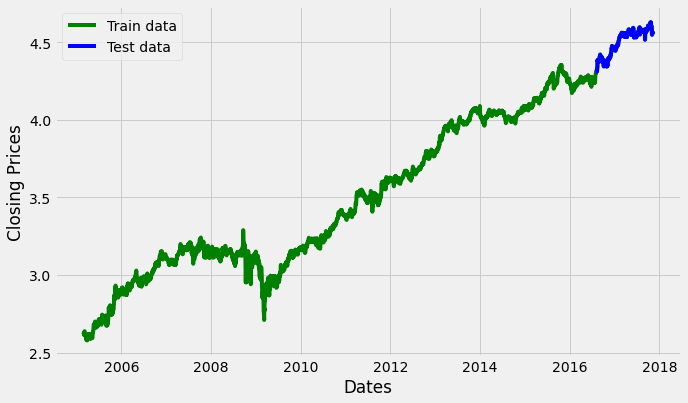

In [ ]:


plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=1.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=3.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=3.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=1.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=1.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=0.83 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=0.92 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 20.695 seconds
  

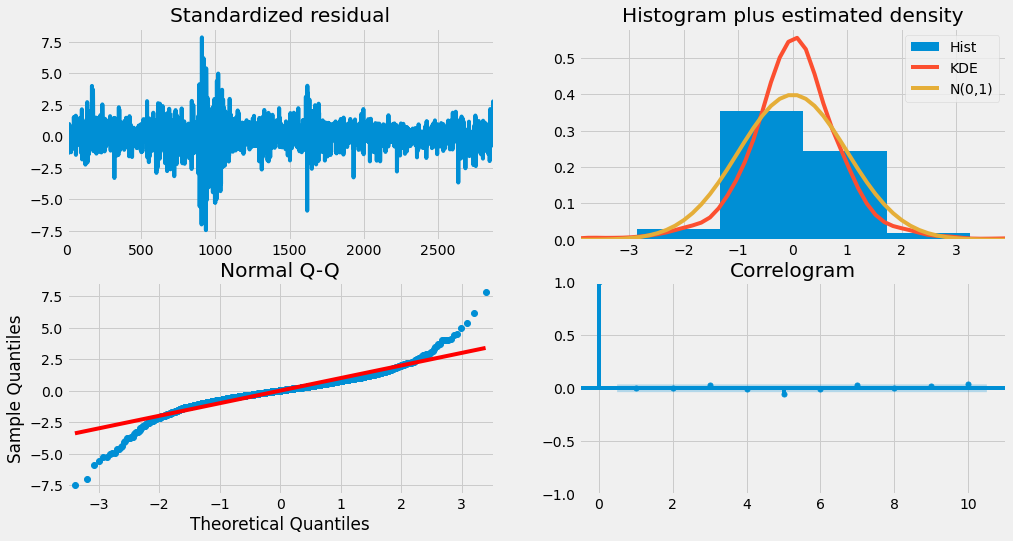

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 2 respectively.**

In [ ]:
#Modeling
# Build Model

model = ARIMA(train_data, order=(1,1,2))

In [ ]:
fitted_model = model.fit()

In [ ]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2880
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8277.634
Date:                Mon, 28 Nov 2022   AIC                         -16547.268
Time:                        23:40:06   BIC                         -16523.407
Sample:                             0   HQIC                        -16538.668
                               - 2880                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8798      0.048     18.311      0.000       0.786       0.974
ma.L1         -0.9897      0.051    -19.433      0.000      -1.090      -0.890
ma.L2          0.0761      0.015      5.089      0.000       0.047       0.105
sigma2         0.0002   2.29e-06     81.372      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):              7202.46
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [ ]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
print(start)
print(end)

2880
3200


In [ ]:
stock_data.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0


In [ ]:
pred = fitted_model.predict(start=start, end=end, type='level')
pred.index = stock_data.index[start:end+1]
print(pred)

Date
2016-08-05    4.303789
2016-08-08    4.302908
2016-08-09    4.302134
2016-08-10    4.301452
2016-08-11    4.300853
                ...   
2017-11-06    4.296463
2017-11-07    4.296463
2017-11-08    4.296463
2017-11-09    4.296463
2017-11-10    4.296463
Name: predicted_mean, Length: 321, dtype: float64


### Ploting the model

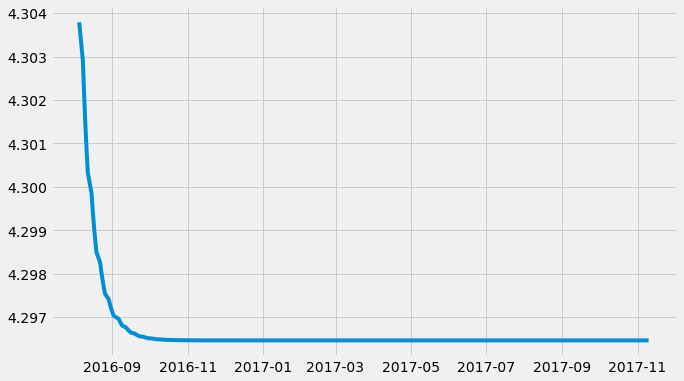

In [ ]:
plt.plot(pred)

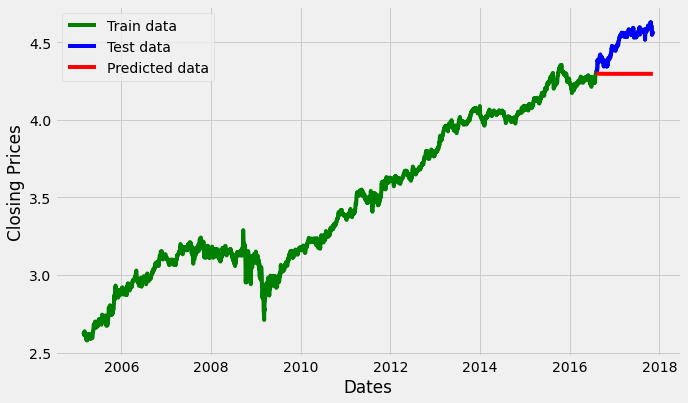

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.plot(pred, 'red', label='Predicted data')
plt.legend()

As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [ ]:

# report performance
mse = mean_squared_error(test_data, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.04959639958016383
MAE: 0.2056683217796404
RMSE: 0.2227024911853566
MAPE: 0.045333861588310466


### Around 2.5% MAPE implies the model is about 97.5% accurate in predicting the next 15 observations.
